In [1]:
import json
import random
import numpy as np

# Function to compute cosine distance
def cosine_distance(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return 1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Load the JSON data
with open('embedding_results.json', 'r') as file:
    results = json.load(file)

In [2]:
paired_results = []

for task in results:
    for test_entry in results[task]['test']:
        # Pair with a random entry from the same task's training set
        same_task_train_entry = random.choice(results[task]['train'])
        same_task_distance = cosine_distance(test_entry['embedding'], same_task_train_entry['embedding'])

        # Get a random task that is not the current task
        different_task = random.choice([t for t in results.keys() if t != task])
        different_task_train_entry = random.choice(results[different_task]['train'])
        different_task_distance = cosine_distance(test_entry['embedding'], different_task_train_entry['embedding'])

        # Record the required details
        paired_results.append({
            'task': task,
            'test_input': test_entry['input'],
            'test_output': test_entry['output'],
            'test_options': test_entry['options'],
            'test_combined_text': test_entry['combined_text'],
            'same_task_combined_text': same_task_train_entry['combined_text'],
            'same_task_distance': same_task_distance,
            'different_task_combined_text': different_task_train_entry['combined_text'],
            'different_task_distance': different_task_distance
        })


In [1]:
import json
import numpy as np

# Function to compute cosine distance
def cosine_distance(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return 1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Load the embedding results
with open('embedding_results.json', 'r') as file:
    embedding_results = json.load(file)

# Load the paired results
with open('paired_embedding_results.json', 'r') as file:
    paired_results = json.load(file)

# Update distances based on the new embedding results
for entry in paired_results:
    task = entry['task']
    test_combined_text = entry['test_combined_text']
    same_task_combined_text = entry['same_task_combined_text']
    different_task_combined_text = entry['different_task_combined_text']

    # Find the test entry in the embedding results
    test_entry = next(e for e in embedding_results[task]['test'] if e['combined_text'] == test_combined_text)
    test_embedding = test_entry['embedding']

    # Find the same task train entry in the embedding results
    same_task_entry = next(e for e in embedding_results[task]['train'] if e['combined_text'] == same_task_combined_text)
    same_task_embedding = same_task_entry['embedding']

    # Find the different task train entry in the embedding results
    for other_task in embedding_results:
        if other_task != task:
            try:
                different_task_entry = next(e for e in embedding_results[other_task]['train'] if e['combined_text'] == different_task_combined_text)
                different_task_embedding = different_task_entry['embedding']
                break
            except StopIteration:
                continue

    # Recalculate distances
    same_task_distance = cosine_distance(test_embedding, same_task_embedding)
    different_task_distance = cosine_distance(test_embedding, different_task_embedding)

    # Update the distances in the paired results
    entry['same_task_distance'] = same_task_distance
    entry['different_task_distance'] = different_task_distance

# Save the updated paired results to a JSON file
with open('paired_embedding_results.json', 'w') as outfile:
    json.dump(paired_results, outfile, indent=4)


In [2]:

# Optionally, save to a JSON file
with open('paired_embedding_results.json', 'w') as outfile:
    json.dump(paired_results, outfile, indent=4)


In [3]:
import openai

def get_response(messages):
    try:
        response = openai.chat.completions.create(
            model="gpt-4-1106-preview",
            temperature=1.0,
            max_tokens=1000,
            messages=messages
        )
        return response.choices[0].message.content  # Adapt based on the actual API response structure
    except Exception as e:
        print(f"API request failed: {e}")
        return "Error: Unable to fetch response."
def format_options(options):
    return ', '.join(options)

In [4]:
for task in paired_results:
    for scenario, context in [("no_context", ""), 
                              ("same_task_context", task['same_task_combined_text']), 
                              ("different_task_context", task['different_task_combined_text'])]:
        
        messages = []
        messages.append({
            "role": "system", 
            "content": """
                        You will be given a question and a context. Your task is to select the \
                        most appropriate answer from the choices provided. Make sure your response \
                        starts with the letter of your choice. For example, if you are given options \
                        'A' or 'B', your response should be 'A' or 'B'. Nothing more, nothing less.
                    """
        })
        messages.append({"role": "assistant", "content": f"Context: {context}"})
        formatted_options = format_options(task['test_options'])
        messages.append({"role": "user", "content": f"The problem is {task['test_input']} and the choices are {formatted_options}"})
        
        response = get_response(messages)
        
        # Store the response in the appropriate scenario
        task[scenario + "_response"] = response



KeyboardInterrupt



In [ ]:
with open('updated_paired_results.json', 'w') as outfile:
    json.dump(paired_results, outfile, indent=4)

In [ ]:
import re

def match_and_convert(response, options):
    # Tokenize the response using regex to handle various word delimiters
    response_tokens = set(re.findall(r'\w+', response.lower()))
    best_match = None
    max_matches = 0
    
    # Check each option for the number of matching tokens in the response
    for option in options:
        option_tokens = set(re.findall(r'\w+', option.lower()))
        matches = len(response_tokens & option_tokens)  # Intersection of sets

        # If this option has more matches than previous ones, update the best match
        if matches > max_matches:
            max_matches = matches
            best_match = option.lower()

    return best_match if best_match is not None else response
# Update responses based on new matching logic
for task in paired_results:
    task['test_output'] = task['test_output'].lower()

    for scenario in ["no_context", "same_task_context", "different_task_context"]:
        scenario_response_key = scenario + "_response"
        if scenario_response_key in task:
            response = task[scenario_response_key]
            matched_response = match_and_convert(response, task['test_options'])
            task[scenario_response_key] = matched_response

# Save the updated results
with open('updated_paired_results.json', 'w') as outfile:
    json.dump(paired_results, outfile, indent=4)


In [1]:
import json
import numpy as np
with open('updated_paired_results.json', 'r') as file:
    paired_results = json.load(file)
task_statistics = {}
selected_task_names=['superglue-cb', 'tweet_eval-stance_hillary', 'ethos-national_origin', 'blimp-anaphor_number_agreement', 'superglue-rte', 'crows_pairs', 'quartz-with_knowledge', 'sick', 'glue-sst2', 'sciq']

for task in selected_task_names:
    same_task_distances = []
    different_task_distances = []
    no_context_scores = []
    same_task_context_scores = []
    different_task_context_scores = []

    for entry in paired_results:
        if entry["task"]!=task:
            continue
        # Collect distances
        same_task_distances.append(entry['same_task_distance'])
        different_task_distances.append(entry['different_task_distance'])

        # Calculate scores
        no_context_scores.append(1 if entry['no_context_response'] == entry['test_output'] else 0)
        same_task_context_scores.append(1 if entry['same_task_context_response'] == entry['test_output'] else 0)
        different_task_context_scores.append(1 if entry['different_task_context_response'] == entry['test_output'] else 0)

    # Compute averages and standard deviations
    task_statistics[task] = {
        'no_context_scores': no_context_scores,
        'same_task_context_scores': same_task_context_scores,
        'different_task_context_scores': different_task_context_scores,
        'avg_same_task_distance': np.mean(same_task_distances),
        'std_same_task_distance': np.std(same_task_distances),
        'avg_different_task_distance': np.mean(different_task_distances),
        'std_different_task_distance': np.std(different_task_distances),
        'avg_score_no_context': np.mean(no_context_scores),
        'std_score_no_context': np.std(no_context_scores),
        'avg_score_same_task_context': np.mean(same_task_context_scores),
        'std_score_same_task_context': np.std(same_task_context_scores),
        'avg_score_different_task_context': np.mean(different_task_context_scores),
        'std_score_different_task_context': np.std(different_task_context_scores)
    }

# Print the results or save them
for task, stats in task_statistics.items():
    print(f"Task: {task}")
    for key, value in stats.items():
        print(f"{key}: {value}")


Task: superglue-cb
no_context_scores: [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
same_task_context_scores: [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1]
different_task_context_scores: [0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]
avg_same_task_distance: 0.20433718845037863
std_same_task_distance: 0.029242634946530673
avg_different_task_di

In [2]:
import pandas as pd
import numpy as np

# Prepare the data for plotting
data = []
for task, stats in task_statistics.items():
    data.append({
        'Task': task,
        'Context Type': 'No Context',
        'Average Score': stats['avg_score_no_context'],
        'SEM': stats['std_score_no_context'] / np.sqrt(len(stats['no_context_scores']))
    })
    data.append({
        'Task': task,
        'Context Type': 'Different Task Context',
        'Average Score': stats['avg_score_different_task_context'],
        'SEM': stats['std_score_different_task_context'] / np.sqrt(len(stats['different_task_context_scores']))
    })
    data.append({
        'Task': task,
        'Context Type': 'Same Task Context',
        'Average Score': stats['avg_score_same_task_context'],
        'SEM': stats['std_score_same_task_context'] / np.sqrt(len(stats['same_task_context_scores']))
    })

df = pd.DataFrame(data)

# Verify the data structure
print(df.head())

                        Task            Context Type  Average Score       SEM
0               superglue-cb              No Context       0.750000  0.046159
1               superglue-cb  Different Task Context       0.522727  0.053245
2               superglue-cb       Same Task Context       0.590909  0.052412
3  tweet_eval-stance_hillary              No Context       0.396040  0.048665
4  tweet_eval-stance_hillary  Different Task Context       0.306931  0.045893


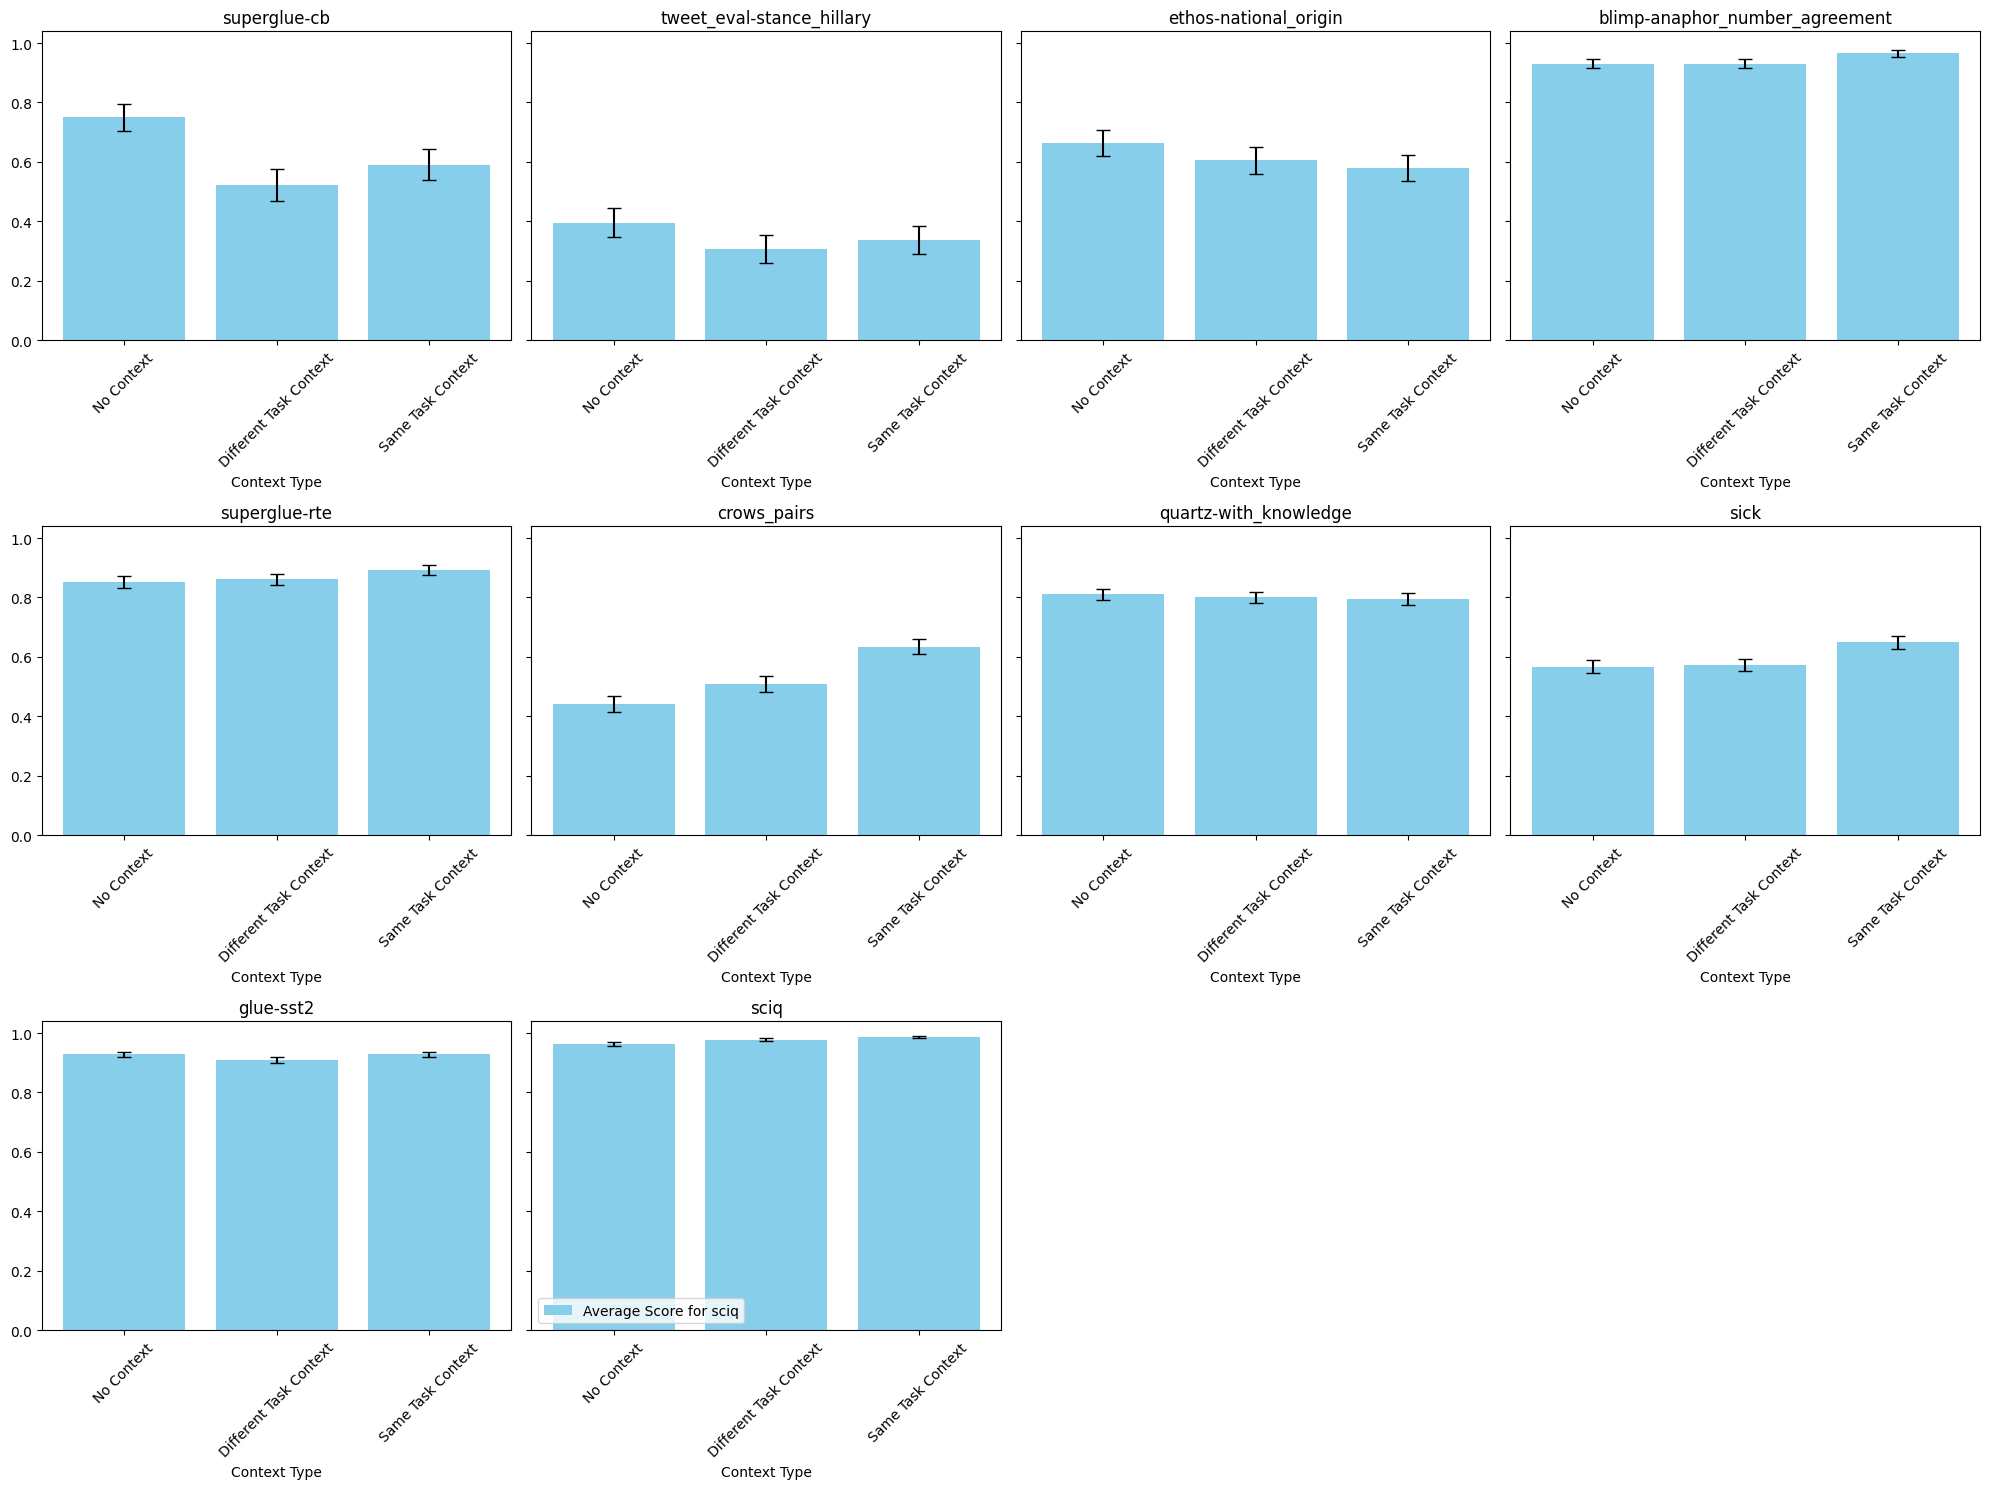

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your original DataFrame with multiple tasks

# Unique tasks to create a panel for each
tasks = df['Task'].unique()
num_tasks = len(tasks)

# Set up a figure with subplots in a 3x4 grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=True)  # Adjust figsize as needed

# Flatten axes array for easier iteration if there are multiple axes
axes = axes.flatten()

# Iterate over each task and corresponding subplot
for ax, task in zip(axes, tasks):
    # Filter data for the current task
    task_data = df[df['Task'] == task]
    # Get order, scores, and errors
    order = task_data['Context Type'].tolist()
    scores = task_data['Average Score'].tolist()
    errors = task_data['SEM'].tolist()

    # Plotting
    ax.bar(order, scores, yerr=errors, capsize=5, color='skyblue', label=f'Average Score for {task}')
    ax.set_title(f'{task}')
    ax.set_xlabel('Context Type')
    ax.set_xticks(np.arange(len(order)))
    ax.set_xticklabels(order, rotation=45)

# Hide empty subplots if tasks are fewer than 12
for i in range(num_tasks, 12):
    fig.delaxes(axes[i])

# General settings
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# Extract all distances from the data
distances = []
for result in paired_results:
    distances.append(result['same_task_distance'])
    distances.append(result['different_task_distance'])

# Calculate the minimum and maximum distance
min_distance = min(distances)
max_distance = max(distances)

# Print the minimum and maximum distances
print("Minimum distance:", min_distance)
print("Maximum distance:", max_distance)

# Define bins based on the range of distances
bins = np.linspace(min_distance, max_distance, num=11)  # Creates 10 equal bins between min and max

# Print the bin edges
print("Bin edges:", bins)

Minimum distance: -2.220446049250313e-16
Maximum distance: 0.405949543485039
Bin edges: [-2.22044605e-16  4.05949543e-02  8.11899087e-02  1.21784863e-01
  1.62379817e-01  2.02974772e-01  2.43569726e-01  2.84164680e-01
  3.24759635e-01  3.65354589e-01  4.05949543e-01]


Bin 1: 0.594 to 0.652
  Count: 218
  Mean Improvement: -0.005
  Standard Deviation: 0.262
  SEM: 0.018
Bin 2: 0.652 to 0.710
  Count: 2300
  Mean Improvement: 0.004
  Standard Deviation: 0.305
  SEM: 0.006
Bin 3: 0.710 to 0.768
  Count: 2322
  Mean Improvement: -0.006
  Standard Deviation: 0.387
  SEM: 0.008
Bin 4: 0.768 to 0.826
  Count: 1659
  Mean Improvement: 0.017
  Standard Deviation: 0.451
  SEM: 0.011
Bin 5: 0.826 to 0.884
  Count: 1264
  Mean Improvement: 0.048
  Standard Deviation: 0.461
  SEM: 0.013
Bin 6: 0.884 to 0.942
  Count: 127
  Mean Improvement: 0.079
  Standard Deviation: 0.446
  SEM: 0.040
Bin 7: 0.942 to 1.000
  Count: 7
  Mean Improvement: 0.000
  Standard Deviation: 0.000
  SEM: 0.000


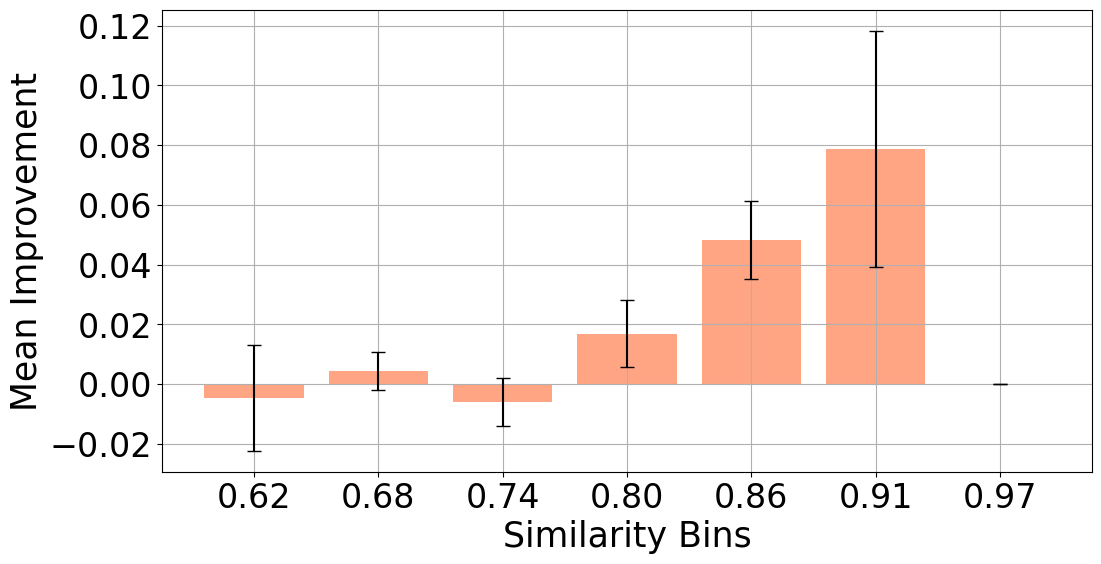

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def bin_similarity(similarity, bins):
    """Categorize similarity into specified bins."""
    return np.digitize(similarity, bins, right=True) - 1

def calculate_statistics(data, bins):
    """Calculate accuracies, accuracy improvements, and statistical measures for all tasks, categorized by bins."""
    context_accuracies = [0] * (len(bins) - 1)
    no_context_accuracies = [0] * (len(bins) - 1)
    counts = [0] * (len(bins) - 1)
    improvements = [[] for _ in range(len(bins) - 1)]  # Collecting all improvements for std calculation

    for item in data:
        for task_type in ['same', 'different']:
            distance = item[f'{task_type}_task_distance']
            similarity = 1 - distance  # Convert distance to similarity
            response = item[f'{task_type}_task_context_response']
            output = item['test_output']
            no_context_response = item['no_context_response']

            bin_index = np.digitize(similarity, bins, right=True) - 1
            if 0 <= bin_index < len(context_accuracies):
                correct_context = response == output
                correct_no_context = no_context_response == output
                context_accuracies[bin_index] += correct_context
                no_context_accuracies[bin_index] += correct_no_context
                counts[bin_index] += 1
                improvements[bin_index].append(correct_context - correct_no_context)

    # Calculate statistics per bin
    average_improvement = [np.mean(imp) if imp else 0 for imp in improvements]
    std = [np.std(imp) if imp else 0 for imp in improvements]
    sem = [s / np.sqrt(len(imp)) if imp else 0 for s, imp in zip(std, improvements)]

    return average_improvement, std, sem, counts


# Calculate min and max similarities
min_distance = min(result['same_task_distance'] for result in paired_results)
min_distance = min(min_distance, min(result['different_task_distance'] for result in paired_results))
max_distance = max(result['same_task_distance'] for result in paired_results)
max_distance = max(max_distance, max(result['different_task_distance'] for result in paired_results))
min_similarity = 1 - max_distance
max_similarity = 1 - min_distance

# Define and adjust bins
bins = np.linspace(min_similarity, max_similarity, num=8)  # Adjust the number of bins if necessary
average_improvement, std, sem, counts = calculate_statistics(paired_results, bins)

# Print bin information
for i in range(len(bins) - 1):
    print(f"Bin {i + 1}: {bins[i]:.3f} to {bins[i + 1]:.3f}")
    print(f"  Count: {counts[i]}")
    print(f"  Mean Improvement: {average_improvement[i]:.3f}")
    print(f"  Standard Deviation: {std[i]:.3f}")
    print(f"  SEM: {sem[i]:.3f}")

# Plotting the results
bin_midpoints = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]
bin_width = np.min(np.diff(bins)) * 0.8  # Calculate bin width as 80% of the smallest bin interval

plt.figure(figsize=(12, 6))
plt.bar(bin_midpoints, average_improvement, width=bin_width, yerr=sem, align='center', alpha=0.7, capsize=5, color="coral")
plt.xlabel('Similarity Bins', fontsize=25)
plt.ylabel('Mean Improvement', fontsize=25)
plt.xticks(bin_midpoints, labels=[f"{m:.2f}" for m in bin_midpoints], fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True)
plt.show()
